In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import Image, display
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
tf.__version__

'1.13.1'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [4]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [5]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
num_epochs = 50
val_steps = 20
MODEL_NAME = 'mobilenetv2'

In [6]:
def draw_losses(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [7]:
image_csv = pd.read_csv('./../data/all.csv')

# Prepend image filenames in train/ with relative path
filenames = image_csv['path'].tolist()
labels = image_csv['label'].tolist()

train_filenames, val_filenames, train_labels, val_labels = train_test_split(filenames,
                                                                            labels,
                                                                            train_size=0.8,
                                                                            random_state=420)

num_train = len(train_filenames)
num_val = len(val_filenames)
output_size = len(set(train_labels + val_labels))

In [8]:
def _parse_fn(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string)
    image_normalized = (tf.cast(image_decoded, tf.float32)/127.5) - 1
    image_resized = tf.image.resize(image_normalized, (IMAGE_SIZE, IMAGE_SIZE))
    return image_resized, label

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((tf.constant(train_filenames), tf.constant(train_labels))).map(_parse_fn).shuffle(buffer_size=10000).batch(BATCH_SIZE)


val_data = tf.data.Dataset.from_tensor_slices((tf.constant(val_filenames), tf.constant(val_labels))).map(_parse_fn).batch(BATCH_SIZE)


In [ ]:
# Base model with Xception
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=IMG_SHAPE, 
                                       include_top=False, 
                                       weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
# Freeze the pre-trained model weights
base_model.trainable = False

# Trainable classification head
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
prediction_layer = tf.keras.layers.Dense(output_size, activation='sigmoid')

# Layer classification head with feature detector
model = tf.keras.Sequential([
    base_model,
    maxpool_layer,
    prediction_layer
])

learning_rate = 0.0001

In [ ]:
csv_logger = CSVLogger('logs/%s.log' % MODEL_NAME)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss='categorical_crossentropy',
             metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 42)                53802     
Total params: 2,311,786
Trainable params: 53,802
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
steps_per_epoch = round(num_train)//BATCH_SIZE

In [ ]:
history = model.fit(train_data.repeat(),
                    epochs=num_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data=val_data.repeat(), 
                    validation_steps=val_steps,
                    callbacks=[csv_logger])

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
523/523 [==============================] - 55s 106ms/step - loss: 2856.3693 - acc: 0.9836 - val_loss: 2804.0933 - val_acc: 0.9734
Epoch 2/50
523/523 [==============================] - 54s 103ms/step - loss: 2852.1860 - acc: 0.9992 - val_loss: 2929.6790 - val_acc: 0.9828
Epoch 3/50
523/523 [==============================] - 54s 103ms/step - loss: 2852.9158 - acc: 0.9991 - val_loss: 2938.9998 - val_acc: 0.9953
Epoch 4/50
523/523 [==============================] - 53s 102ms/step - loss: 2853.3135 - acc: 0.9989 - val_loss: 2789.1310 - val_acc: 0.9984
Epoch 5/50
523/523 [==============================] - 54s 103ms/step - loss: 2851.6982 - acc: 0.9992 - val_loss: 2831.8105 - val_acc: 0.9969
Epoch 6/50
523/523 [==============================] - 53s 102ms/step - loss: 2854.8086 - acc: 0.9995 - val_loss: 2813.6594 - val_acc: 0.9984
Epoch 7/50
523/523 [==============================] - 54s 103ms/step - loss: 2852.1316 - acc: 0.9994 - val

In [ ]:
# Save fine-tuned model weights
model.save_weights('./models/weights_%s.h5' % MODEL_NAME)

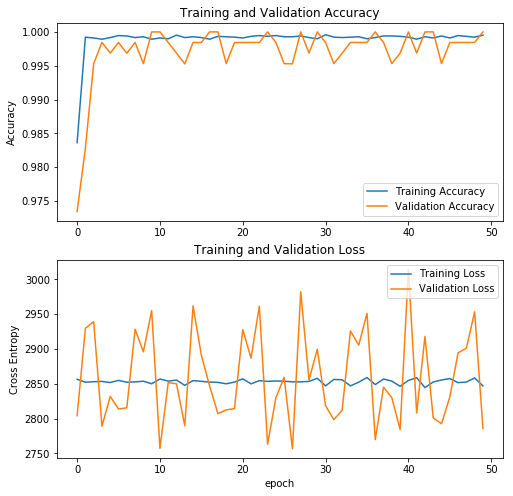

In [ ]:
draw_losses(history)

In [ ]:
# Unfreeze all layers of MobileNetV2
base_model.trainable = True

# Refreeze layers until the layers we want to fine-tune
for layer in base_model.layers[:100]:
    layer.trainable =  False

# Use a lower learning rate
lr_finetune = learning_rate / 10

# Recompile the model
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=lr_finetune),
              metrics=['acc'])

# Increase training epochs for fine-tuning
fine_tune_epochs = 50
total_epochs =  num_epochs + fine_tune_epochs

# Fine-tune model
# Note: Set initial_epoch to begin training after epoch 30 since we
# previously trained for 30 epochs.

history_fine = model.fit(train_data.repeat(), 
                  steps_per_epoch = steps_per_epoch,
                  epochs=total_epochs, 
                  initial_epoch = num_epochs,
                  validation_data=val_data.repeat(), 
                  validation_steps=val_steps,
                    callbacks=[csv_logger])

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 51/100
523/523 [==============================] - 62s 119ms/step - loss: 2852.8332 - acc: 0.9993 - val_loss: 2804.0933 - val_acc: 0.9984
Epoch 52/100
523/523 [==============================] - 59s 114ms/step - loss: 2852.7094 - acc: 0.9995 - val_loss: 2929.6791 - val_acc: 0.9984
Epoch 53/100
523/523 [==============================] - 60s 114ms/step - loss: 2855.3376 - acc: 0.9993 - val_loss: 2938.9998 - val_acc: 0.9984
Epoch 54/100
523/523 [==============================] - 60s 115ms/step - loss: 2853.3754 - acc: 0.9993 - val_loss: 2789.1309 - val_acc: 1.0000
Epoch 55/100
  4/523 [..............................] - ETA: 32s - loss: 2776.6213 - acc: 1.0000

In [ ]:
# Save fine-tuned model weights
model.save_weights('./models/weights_finetuned_%s.h5' % MODEL_NAME)

In [ ]:
draw_losses(history_fine)